In [1]:
# This notebook has been modified (cleaned up) from the exact version used in the thesis,
# and verified to work with versions seen in the end.

In [2]:
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit import execute, Aer, BasicAer
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout

from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import MCMT
from qiskit.providers.ibmq.managed import IBMQJobManager

In [13]:
# prepare one qubit and inverse if dagger == 1
def apply_secret_state(state, qubit, circ, dagger):    
    functionmap = {
        'x':circ.x,
        'y':circ.y,
        'z':circ.z,
        'h':circ.h,
        't':circ.t,
    } # if dagger true do state from left to right
    if dagger: functionmap['t'] = qc.tdg
        
    if dagger:
        [functionmap[unitary](qubit) for unitary in state] # 
    else:
        [functionmap[unitary](qubit) for unitary in state[::-1]] # if dagger not true 

In [14]:
# Prepare an EPR pair, could be made more modular, i.e. taking input qubits instead
def create_EPR_pair(basis, qubits, qc):
#    qc.x(q[2])
    qc.h(q[1])
    qc.cx(q[1],q[2]),
    if (basis == 'phi-'):
        qc.x(q[1]),
    if (basis == 'psi+'):
        qc.x(q[2]),
    if (basis == 'psi-'):
        qc.x(q[1])
        qc.x(q[2])

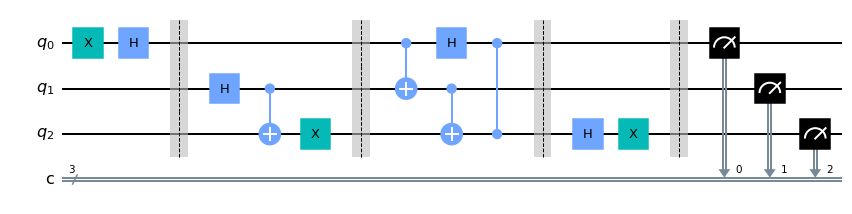

In [19]:
# q[0] Has the state to be teleported
# q[1] Alice's EPR qubit
# q[2] Bob's EPR qubit
# Quantum Circuit
n = 3
q = QuantumRegister(n, name='q')
c = ClassicalRegister(n, name='c')
qc = QuantumCircuit(q, c, name='qc')
secret_state = 'hx' # gates working x,y,z,h,t #applied in order from right to left
basis = 'psi+' # bases: phi+, phi-, psi+, psi-


# Apply secret state to specific qubit
apply_secret_state(secret_state, q[0], qc, dagger = 0)
qc.barrier()

# Create the entangled EPR pair for Alice & Bob
create_EPR_pair(basis, q, qc)
qc.barrier()

# Teleportation protocol
qc.cx(q[0],q[1])
qc.h(q[0])

qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()

# if protocol worked q[2] = secret_state|0>

apply_secret_state(secret_state, q[2], qc, dagger=1)
qc.barrier()
for i in range(n):
    qc.measure(i,i)

qc.draw()

In [20]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

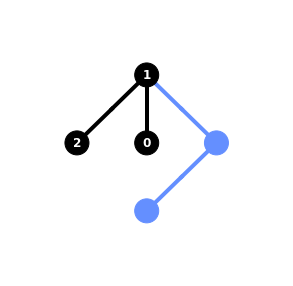

In [22]:
provider = IBMQ.get_provider(hub='ibm-q')
#provider.backends()
backend = provider.get_backend('ibmq_quito') #Ourense is no more, some other picked instead
import inspect
inspect.signature(transpile)
circ = transpile(qc, backend=backend, optimization_level=3)
plot_circuit_layout(circ, backend)

In [23]:
shots = 8192
circ = transpile(circ, backend=backend)
name = 'Quantum Teleportation ' + str(n) + ' qubits'
## Run circuits with jobmanager on IBM systems
job_manager = IBMQJobManager()
jobs = job_manager.run([circ],backend=backend,name=name,shots=shots)

In [25]:
jobs.statuses()

[<JobStatus.DONE: 'job has successfully run'>]

In [24]:
# Run Simulation
backend = BasicAer.get_backend('qasm_simulator')
job_sim = execute(qc, backend=backend, shots=8192)

In [30]:
# Store results
exp_result = jobs.results().get_counts(circ)
sim_result = job_sim.result().get_counts(qc)

/usr/local/Cellar/jupyterlab/3.0.12/libexec/lib/python3.9/site-packages/qiskit/providers/ibmq/managed/managedjobset.py:394: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  for i, exp in enumerate(job.qobj().experiments):


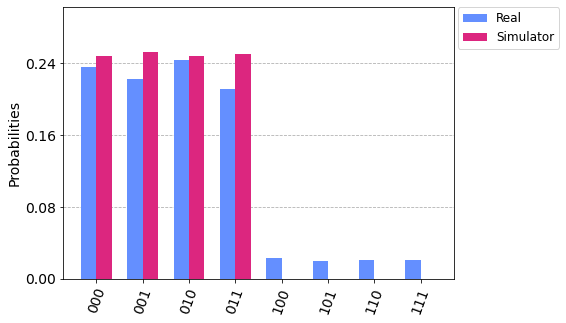

In [31]:
legend = ['Real', 'Simulator']
plot_histogram([exp_result, sim_result], legend=legend, bar_labels=False)

In [27]:
print(exp_result)

{'000': 1937, '001': 1826, '010': 1998, '011': 1730, '100': 188, '101': 164, '110': 174, '111': 175}


In [32]:
import qiskit
for i in qiskit.__qiskit_version__.items():
    print(i)

('qiskit-terra', '0.17.1')
('qiskit-aer', '0.8.1')
('qiskit-ignis', '0.6.0')
('qiskit-ibmq-provider', '0.12.3')
('qiskit-aqua', '0.9.1')
('qiskit', '0.25.2')
('qiskit-nature', None)
('qiskit-finance', None)
('qiskit-optimization', None)
('qiskit-machine-learning', None)
